<a href="https://colab.research.google.com/github/hemanths03/CS6910/blob/main/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
!pip install wandb

In [66]:
import wandb
!wandb login

wandb: Currently logged in as: cs21m027_cs21m011 (use `wandb login --relogin` to force relogin)


In [67]:
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.metrics import log_loss
from keras.datasets import fashion_mnist

#Loading data 

In [68]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
labels = ["T-shirt/Top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]
N , a , b = train_images.shape
#Dimesion of each Datapoint will be a*b
x = a*b
d = x
nl = len(labels)

#Function for question_1


In [69]:
def show_images(train_images , train_labels , desc):
  #run = wandb.init(entity="cs21m027_cs21m011", project="DL_ASG_1_final")
  #run.name = "Question_1"
  plot = []
  m=0
  n=0
  k=0
  fig, axes = plt.subplots(2, 5, figsize=(12.5,6))
  for i in range(1000):
    if train_labels[i]==k:
      ax = axes[m,n]
      ax.imshow(train_images[i], cmap='gray')
      ax.set_title('Class='+str(train_labels[i])+', Label='+str(desc[train_labels[i]]))
      plot.append(wandb.Image(train_images[i],caption= 'Class='+str(train_labels[i])+', Label='+str(desc[train_labels[i]])))
      n=n+1
      k=k+1
      if(n==5):
        m=1
        n=0
    if k==10:
      break
  plt.tight_layout()
  plt.show()
  wandb.log({"images":plot})

#Propecessing of data



In [70]:
#Flattening we are converting the 28*28 data point as 784*1 data point
flatted_train_images =  np.array([train_images[i].flatten() for i in range(len(train_images))])
#Same transition for testdata
flatted_test_images =  np.array([test_images[i].flatten() for i in range(len(test_images))])

In [71]:
#getting train data and validation data from training data
from sklearn.model_selection import train_test_split
train_x, valid_x, cat_train_y, cat_val_y = train_test_split(flatted_train_images, train_labels, test_size=0.1, stratify = train_labels ,random_state=42)

In [72]:
#One hot encoding of categorical labels 
def encode(data , nl):
  encode_data = np.array( [ [0]*nl for i in range(len(data))] )
  for i in range(len(data)):
    actual_label = data[i]
    encode_data[i][actual_label] = 1
  return encode_data

In [73]:
train_y = encode(cat_train_y , nl)
valid_y = encode(cat_val_y , nl)
test_y = encode(test_labels , nl)

In [74]:
#Normalizing the data
mean = np.mean(train_x , axis = 0)
train_x = (train_x - mean) /255
valid_x = (valid_x - mean)/255
test_x = (flatted_test_images - mean)/255

In [75]:
print(train_x.shape)
print(valid_x.shape)
print(test_x.shape)
print(train_y.shape)
print(valid_y.shape)
print(test_y.shape)

(54000, 784)
(6000, 784)
(10000, 784)
(54000, 10)
(6000, 10)
(10000, 10)


#Activation functions


In [76]:
def sigmoid(x):
    temp = []
    for i in range(len(x)):
      temp.append(1/(1 + np.exp(-(float(x[i])))))
    return np.array(temp)

def tanh(x):
    temp = []
    for i in range(len(x)):
      temp.append(np.tanh(x[i]))
    return np.array(temp)

def relu(x):
    temp = []
    for i in range(len(x)):
      temp.append(max(0,x[i]))
    return np.array(temp)

def softmax(x):
    temp = []
    sum = 0
    for i in range(len(x)):
      sum += np.exp(float(x[i]))
    for i in range(len(x)):
      temp.append( np.exp(float(x[i])) / sum)
    return np.array(temp)

def derivative_sigmoid(x):
    return x*(1 - x)

def derivative_tanh(x):
    return 1-np.square(x)

def derivative_relu(x):
    temp = []
    for i in range(len(x)):
      if x[i]>0:
        temp.append(1)
      else:
        temp.append(0)
    return np.array(temp)

#Network initialization

In [77]:
def initialize_zeros(dim,hl,ol):
  w = [np.array([])]
  b = [np.array([])]
  for i in range(len(hl)):
    b.append(np.zeros(hl[i]))
    if(i == 0):
      w.append(np.zeros((hl[i],d)))
    else:
      w.append(np.zeros((hl[i],hl[i - 1])))

  for i in range(len(ol)):
    b.append(np.zeros(ol[i]))
    w.append(np.zeros((ol[i],hl[-1])))
  return w , b

In [78]:
def initialize_network(dim, hl, ol, method):
  W = [np.array([])]
  b = [np.array([])]
  np.random.seed(2)
  #Random intialization
  if(method=='random'):
    for i in range(len(hl)):
      b.append(np.random.randn(hl[i]))
      if(i == 0):
        W.append(np.random.randn(hl[i],dim))
      else:
        W.append(np.random.randn(hl[i],hl[i - 1]))
    for i in range(len(ol)):
      b.append(np.random.randn(ol[i]))
      W.append(np.random.randn(ol[i],hl[-1]))
      
  #Xavier Initialization
  else:
    for i in range(len(hl)):
      b.append(np.random.randn(hl[i]))
      if(i == 0):
        W.append(np.random.randn(hl[i],dim ) * np.sqrt(1/dim))
      else:
        W.append(np.random.randn(hl[i],hl[i-1]) * np.sqrt(1/hl[i-1]))
    for i in range(len(ol)):
      b.append(np.random.randn(ol[i]))
      W.append(np.random.randn(ol[i],hl[-1]) * np.sqrt(1/hl[-1]))

  return W,b

#Forward Propagation

In [79]:
def forward_propagation(W,b,x,method):
    a = [[]]
    h = [[]]
    h[0] = x 
    num_layers = (len(W)-1)
    c = []
    d = []
    if method=='sigmoid':
        for i in range(1 , num_layers):
            c = np.dot( W[i], h[i-1] ) + b[i]
            a.append(c)
            d = sigmoid(c)
            h.append(d)

    elif method=='tanh':
        for i in range(1 , num_layers):
            c = np.dot( W[i], h[i-1] ) + b[i]
            a.append(c)
            d = tanh(c)
            h.append(d)

    elif method=='relu':
        for i in range(1 , num_layers):
            c = np.dot( W[i], h[i-1] ) + b[i]
            a.append(c)
            d = relu(c)
            h.append(d)

    c = np.dot( W[num_layers], h[num_layers-1] ) + b[num_layers]
    a.append(c)
    d = softmax(c)
    h.append(d)

    return a,h

#Backward Propagation

In [80]:
def back_prop(W,h,x,y,y_pred,act_fun,loss_fun):
  del_W,del_b=[[]],[[]]

  #Computing output grad wrt Cross Entropy Loss function
  if loss_fun == "cross_entropy" :
    del_a = (y_pred - y)
    
  #Computing output grad wrt Squared Error Loss function
  else:
    y_label = y_pred[np.argmax(y)]
    del_a = 2 * (y_label - 1) * y_label * ( y - y_pred )

  for i in range(len(W)-1, 0, -1):

    #computing gradients wrt parameters W,b
    dW = np.array(np.dot(np.matrix(del_a).T , np.matrix(h[i-1])))
    db = np.array( del_a )

    #computing gradients wrt below layer activation function
    dh = np.dot( np.transpose(W[i]), del_a )

    #computing gradients wrt below layer pre-activation function
    if act_fun == "sigmoid":
      del_a = dh * derivative_sigmoid( h[i - 1] )
    
    elif act_fun == "tanh":
      del_a = dh * derivative_tanh( h[i - 1] )
    
    elif act_fun == "relu":
      del_a = dh * derivative_relu( h[i - 1] )

    del_W.insert(1, dW)
    del_b.insert(1, db)

  return del_W, del_b

#Stochastic Gradient Descent optimizer

In [81]:
def stochastic_gradient_descent(train_x,train_y,valid_x,valid_y,d,hl,ol,act_fun,loss_fun,epochs,eta,strat,alpha,batch):
  #Initializing the weights and biases based on given strategy
  W,b = initialize_network(d, hl, ol, strat)
  dw , db = initialize_zeros(784,hl,ol)

  seen = 0
  for e in range(epochs):
    
    for it, (x, y) in enumerate(zip(train_x, train_y)):
      seen += 1
      a,h = forward_propagation(W, b, x, act_fun)
      y_pred=h[len(h)-1]
      tdw,tdb=back_prop(W, h, x, y, y_pred, act_fun, loss_fun)

      for i in range(len(tdw)):
        dw[i] += tdw[i]
        db[i] += tdb[i]

      if(seen==batch or it==len(train_x)-1):
        seen = 0

        for i, (weight, deriv) in enumerate(zip(W, dw)):
          W[i] = weight - eta * np.array(deriv)

        for i, (bias, deriv) in enumerate(zip(b, db)):
          b[i] = bias - eta * np.array(deriv)
        
        dw , db = initialize_zeros(784,hl,ol)

    val_acc, val_loss,yt_val,ypred_train = get_predictions_accuracy(W, b, valid_x, valid_y, act_fun, loss_fun)
    train_acc, train_loss,yt_train,ypred_train = get_predictions_accuracy(W, b, train_x, train_y, act_fun, loss_fun)
    test_acc, test_loss,yt_test,ypred_test = get_predictions_accuracy(W, b, test_x, test_y, act_fun, loss_fun)

    print("epoch:" , e+1 , " "+loss_fun+" ", "train_acc :" , train_acc , "valid_acc :" , val_acc , "test_acc :" , test_acc)
    
    if loss_fun=="cross_entropy":
      wandb.log({
          "Epoch": e+1,
          "Train Loss": train_loss,
          "Train Acc": train_acc,
          "Valid Loss": val_loss,
          "Valid Acc": val_acc})
    else:
      wandb.log({
          "Train Loss (squared_error)": train_loss,
          "Train Acc (squared_error)": train_acc,
          "Valid Loss (squared_error)": val_loss,
          "Valid Acc (squared_error)": val_acc})
  return W,b

#Momentum Based Gradient Descent 

In [82]:
def momentum_gradient_descent(train_x,train_y,valid_x,valid_y,d,hl,ol,act_fun,loss_fun,epochs,eta,strat,alpha,batch):
  W,b=initialize_network(d, hl, ol, strat)
  dw , db = initialize_zeros(784,hl,ol)
  prev_w , prev_b = initialize_zeros(784,hl,ol)
  gamma=0.9
  seen=0

  for e in range(epochs):
    #dw , db = initialize_zeros(784,hl,ol)
    for it, (x, y) in enumerate(zip(train_x, train_y)):
      seen+=1
      a,h = forward_propagation(W, b, x, act_fun)
      y_pred=h[len(h)-1]
      
      tdw,tdb=back_prop(W, h, x, y, y_pred, act_fun, loss_fun)
  
      for i in range(len(tdw)):
        dw[i] += tdw[i]
        db[i] += tdb[i]
    
      if(seen==batch or it==len(train_x)-1):
        seen=0
        for i, (weight, deriv) in enumerate(zip(W, dw)):
          W[i] = weight - eta * np.array(deriv) - gamma*prev_w[i]
          prev_w[i] = eta * np.array(deriv) + gamma*prev_w[i]

        for i, (bias, deriv) in enumerate(zip(b, db)):
          b[i] = bias - eta * np.array(deriv) - gamma*prev_b[i]
          prev_b[i] = eta * np.array(deriv) + gamma*prev_b[i]

        dw , db = initialize_zeros(784,hl,ol)

    val_acc, val_loss,yt_val,ypred_train = get_predictions_accuracy(W, b, valid_x, valid_y, act_fun, loss_fun)
    train_acc, train_loss,yt_train,ypred_train = get_predictions_accuracy(W, b, train_x, train_y, act_fun, loss_fun)
    test_acc, test_loss,yt_test,ypred_test = get_predictions_accuracy(W, b, test_x, test_y, act_fun, loss_fun)

    print("epoch:" , e+1 , " "+loss_fun+" ", "train_acc :" , train_acc , "valid_acc :" , val_acc , "test_acc :" , test_acc)
    
    if loss_fun=="cross_entropy":
      wandb.log({
          "Epoch": e+1,
          "Train Loss": train_loss,
          "Train Acc": train_acc,
          "Valid Loss": val_loss,
          "Valid Acc": val_acc})
    else:
      wandb.log({
          "Train Loss (squared_error)": train_loss,
          "Train Acc (squared_error)": train_acc,
          "Valid Loss (squared_error)": val_loss,
          "Valid Acc (squared_error)": val_acc})
  return W,b

#Nesterov Accelerated Gradient Descent

In [83]:
def nesterov_gradient_descent(train_x,train_y,valid_x,valid_y,d,hl,ol,act_fun,loss_fun,epochs,eta,strat,alpha,batch):
  W,b=initialize_network(d, hl, ol, strat)

  gamma=0.9
  seen=0

  
  prev_w , prev_b = initialize_zeros(784,hl,ol)
  v_w , v_b =initialize_zeros(784,hl,ol)

  dw , db = initialize_zeros(784,hl,ol)
  tw , tb = initialize_zeros(784,hl,ol)

  for e in range(epochs):

    for i in range(len(W)):
      v_w[i] = gamma*prev_w[i]
      v_b[i] = gamma*prev_b[i]
    

    for i in range(len(W)):
      tw[i] = W[i] - v_w[i]
      tb[i] = b[i] - v_b[i]
  
    for it, (x, y) in enumerate(zip(train_x, train_y)):
      seen+=1

      a,h = forward_propagation(tw, tb, x, act_fun)
      y_pred=h[len(h)-1]
      
      tdw,tdb=back_prop(tw, h, x, y, y_pred, act_fun, loss_fun)
      
      for i in range(len(tdw)):
        dw[i] += tdw[i]
        db[i] += tdb[i]

      if seen==batch or it == len(train_x)-1:
        seen=0
        for i, (weight, deriv) in enumerate(zip(W, dw)):
          v_w[i] = gamma*prev_w[i] + eta*np.array(deriv)
          W[i] = weight - v_w[i]
          tw[i] = W[i]
          prev_w = v_w

        for i, (bias, deriv) in enumerate(zip(b, db)):
          v_b[i] = gamma*prev_b[i] + eta*np.array(deriv)
          b[i] = bias - v_b[i]
          tb[i] = b[i]
          prev_b = v_b
        
        dw , db = initialize_zeros(784,hl,ol)

    val_acc, val_loss,yt_val,ypred_train = get_predictions_accuracy(W, b, valid_x, valid_y, act_fun, loss_fun)
    train_acc, train_loss,yt_train,ypred_train = get_predictions_accuracy(W, b, train_x, train_y, act_fun, loss_fun)
    test_acc, test_loss,yt_test,ypred_test = get_predictions_accuracy(W, b, test_x, test_y, act_fun, loss_fun)

    print("epoch:" , e+1 , " "+loss_fun+" ", "train_acc :" , train_acc , "valid_acc :" , val_acc , "test_acc :" , test_acc)
    
    if loss_fun=="cross_entropy":
      wandb.log({
          "Epoch": e+1,
          "Train Loss": train_loss,
          "Train Acc": train_acc,
          "Valid Loss": val_loss,
          "Valid Acc": val_acc})
    else:
      wandb.log({
          "Train Loss (squared_error)": train_loss,
          "Train Acc (squared_error)": train_acc,
          "Valid Loss (squared_error)": val_loss,
          "Valid Acc (squared_error)": val_acc})
  return W,b

#RMS_Prop Optimizer

In [84]:
def rmsprop(train_x,train_y,valid_x,valid_y,d,hl,ol,act_fun,loss_fun,epochs,eta,strat,alpha,batch):
  W,b=initialize_network(d, hl, ol, strat)
  seen=0
  
  prev_w , prev_b = initialize_zeros(784,hl,ol)
  dw , db = initialize_zeros(784,hl,ol)
  eps , beta = 1e-8 , 0.9

  for e in range(epochs):
  
    for it, (x, y) in enumerate(zip(train_x, train_y)):
      seen+=1
      a,h = forward_propagation(W, b, x, act_fun)
      y_pred=h[len(h)-1]
      
      tdw,tdb=back_prop(W, h, x, y, y_pred, act_fun, loss_fun)
      
      for i in range(len(tdw)):
        dw[i] += tdw[i]
        db[i] += tdb[i]

      if seen==batch or it == len(train_x)-1:

        seen=0

        for i in range(len(W)):
          prev_w[i] = beta*prev_w[i] + (1-beta)*(dw[i]**2)
          prev_b[i] = beta*prev_b[i] + (1-beta)*(db[i]**2)

        for i, (weight, deriv) in enumerate(zip(W, dw)):
          W[i] = weight - (eta / np.sqrt(prev_w[i] + eps)) * np.array(deriv)

        for i, (bias, deriv) in enumerate(zip(b, db)):
          b[i] = bias - (eta / np.sqrt(prev_b[i] + eps)) * np.array(deriv)
        
        dw , db = initialize_zeros(784,hl,ol)

    val_acc, val_loss,yt_val,ypred_train = get_predictions_accuracy(W, b, valid_x, valid_y, act_fun, loss_fun)
    train_acc, train_loss,yt_train,ypred_train = get_predictions_accuracy(W, b, train_x, train_y, act_fun, loss_fun)
    test_acc, test_loss,yt_test,ypred_test = get_predictions_accuracy(W, b, test_x, test_y, act_fun, loss_fun)

    print("epoch:" , e+1 , " "+loss_fun+" ", "train_acc :" , train_acc , "valid_acc :" , val_acc , "test_acc :" , test_acc)
    
    if loss_fun=="cross_entropy":
      wandb.log({
          "Epoch": e+1,
          "Train Loss": train_loss,
          "Train Acc": train_acc,
          "Valid Loss": val_loss,
          "Valid Acc": val_acc})
    else:
      wandb.log({
          "Train Loss (squared_error)": train_loss,
          "Train Acc (squared_error)": train_acc,
          "Valid Loss (squared_error)": val_loss,
          "Valid Acc (squared_error)": val_acc})
  return W,b

#Adam Optimizer

In [85]:
def adaptive_moments(train_x,train_y,valid_x,valid_y,d,hl,ol,act_fun,loss_fun,epochs,eta,strat,alpha,batch):
  W,b=initialize_network(d, hl, ol, strat)
  seen=0
  c=0
  v_w , v_b = initialize_zeros(784,hl,ol)
  dw , db = initialize_zeros(784,hl,ol)
  m_w , m_b = initialize_zeros(784,hl,ol)
  eps , beta1 , beta2 = 1e-8 , 0.9 , 0.99

  m_w_hat , m_b_hat = initialize_zeros(784,hl,ol)
  v_w_hat , v_b_hat = initialize_zeros(784,hl,ol)

  for e in range(epochs):
  
    for it, (x, y) in enumerate(zip(train_x, train_y)):
      seen+=1
      a,h = forward_propagation(W, b, x, act_fun)
      y_pred=h[len(h)-1]
      
      tdw,tdb=back_prop(W, h, x, y, y_pred, act_fun, loss_fun)
      
      for i in range(len(tdw)):
        dw[i] += tdw[i]
        db[i] += tdb[i]

      if seen==batch or it == len(train_x)-1:

        seen=0
        c+=1
        for i in range(len(W)):
          m_w[i] = beta1 * m_w[i] + (1-beta1) * dw[i]
          m_b[i] = beta1 * m_b[i] + (1-beta1) * db[i]

          v_w[i] = beta2 * v_w[i] + (1-beta2) * (dw[i]**2)
          v_b[i] = beta2 * v_b[i] + (1-beta2) * (db[i]**2)

        for i in range(len(W)):
          m_w_hat[i] = m_w[i] / (1 - np.power(beta1,c))
          m_b_hat[i] = m_b[i] / (1 - np.power(beta1,c))

          v_w_hat[i] = v_w[i] / (1 - np.power(beta2,c))
          v_b_hat[i] = v_b[i] / (1 - np.power(beta2,c))

        for i, (weight, deriv) in enumerate(zip(W, dw)):
          W[i] = weight - (eta / np.sqrt(v_w_hat[i] + eps)) * m_w_hat[i]

        for i, (bias, deriv) in enumerate(zip(b, db)):
          b[i] = bias - (eta / np.sqrt(v_b_hat[i] + eps)) * m_b_hat[i]
        
        dw , db = initialize_zeros(784,hl,ol)

    val_acc, val_loss,yt_val,ypred_train = get_predictions_accuracy(W, b, valid_x, valid_y, act_fun, loss_fun)
    train_acc, train_loss,yt_train,ypred_train = get_predictions_accuracy(W, b, train_x, train_y, act_fun, loss_fun)
    test_acc, test_loss,yt_test,ypred_test = get_predictions_accuracy(W, b, test_x, test_y, act_fun, loss_fun)

    print("epoch:" , e+1 , " "+loss_fun+" ", "train_acc :" , train_acc , "valid_acc :" , val_acc , "test_acc :" , test_acc)
    
    if loss_fun=="cross_entropy":
      wandb.log({
          "Epoch": e+1,
          "Train Loss": train_loss,
          "Train Acc": train_acc,
          "Valid Loss": val_loss,
          "Valid Acc": val_acc})
    else:
      wandb.log({
          "Train Loss (squared_error)": train_loss,
          "Train Acc (squared_error)": train_acc,
          "Valid Loss (squared_error)": val_loss,
          "Valid Acc (squared_error)": val_acc})
  return W,b

#Nadam Optimizer

In [86]:
def nadam(train_x,train_y,valid_x,valid_y,d,hl,ol,act_fun,loss_fun,epochs,eta,strat,alpha,batch):
  W,b=initialize_network(d, hl, ol, strat)
  seen=0
  c=0
  v_w , v_b = initialize_zeros(784,hl,ol)
  dw , db = initialize_zeros(784,hl,ol)
  m_w , m_b = initialize_zeros(784,hl,ol)
  eps , beta1 , beta2 = 1e-8 , 0.9 , 0.99

  m_w_hat , m_b_hat = initialize_zeros(784,hl,ol)
  v_w_hat , v_b_hat = initialize_zeros(784,hl,ol)

  for e in range(epochs):
  
    for it, (x, y) in enumerate(zip(train_x, train_y)):
      seen+=1
      a,h = forward_propagation(W, b, x, act_fun)
      y_pred=h[len(h)-1]
      
      tdw,tdb=back_prop(W, h, x, y, y_pred, act_fun, loss_fun)
      
      for i in range(len(tdw)):
        dw[i] += tdw[i]
        db[i] += tdb[i]

      if seen==batch or it == len(train_x)-1:

        seen=0
        c+=1
        for i in range(len(W)):
          m_w[i] = beta1 * m_w[i] + (1-beta1) * dw[i]
          m_b[i] = beta1 * m_b[i] + (1-beta1) * db[i]

          v_w[i] = beta2 * v_w[i] + (1-beta2) * (dw[i]**2)
          v_b[i] = beta2 * v_b[i] + (1-beta2) * (db[i]**2)

        for i in range(len(W)):
          m_w_hat[i] = ( (beta1 * m_w[i]) + ( (1 - beta1) * dw[i] ) )/ (1 - np.power(beta1,c))
          m_b_hat[i] = ( (beta1 * m_b[i]) + ( (1 - beta1) * db[i] ) )/ (1 - np.power(beta1,c))

          v_w_hat[i] = v_w[i] / (1 - np.power(beta2,c))
          v_b_hat[i] = v_b[i] / (1 - np.power(beta2,c))

        for i, (weight, deriv) in enumerate(zip(W, dw)):
          W[i] = weight - (eta / np.sqrt(v_w_hat[i] + eps)) * m_w_hat[i]

        for i, (bias, deriv) in enumerate(zip(b, db)):
          b[i] = bias - (eta / np.sqrt(v_b_hat[i] + eps)) * m_b_hat[i]
        
        dw , db = initialize_zeros(784,hl,ol)

    val_acc, val_loss,yt_val,ypred_train = get_predictions_accuracy(W, b, valid_x, valid_y, act_fun, loss_fun)
    train_acc, train_loss,yt_train,ypred_train = get_predictions_accuracy(W, b, train_x, train_y, act_fun, loss_fun)
    test_acc, test_loss,yt_test,ypred_test = get_predictions_accuracy(W, b, test_x, test_y, act_fun, loss_fun)

    print("epoch:" , e+1 , " "+loss_fun+" ", "train_acc :" , train_acc , "valid_acc :" , val_acc , "test_acc :" , test_acc)
    
    if loss_fun=="cross_entropy":
      wandb.log({
          "Epoch": e+1,
          "Train Loss": train_loss,
          "Train Acc": train_acc,
          "Valid Loss": val_loss,
          "Valid Acc": val_acc})
    else:
      wandb.log({
          "Train Loss (squared_error)": train_loss,
          "Train Acc (squared_error)": train_acc,
          "Valid Loss (squared_error)": val_loss,
          "Valid Acc (squared_error)": val_acc})
  return W,b

#Confusion_matrix

In [87]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
import plotly.express as px
import pandas as pd
def get_confusion_matrix(y_true , y_pred , class_names , figsize=(20,20)):
    cm = confusion_matrix(y_true, y_pred, labels=class_names)
    fontsize = 14
    r=class_names[::-1]
    #z_text = [[str(y_true) for y_true in y_pred] for y_pred in cm]

    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    h = [ [0 for _ in range(len(class_names))] for _ in range(len(class_names)) ]
    #h = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%% <br> %d/%d' % (p, c, s)
                h[i][j] = '%d %s are correctly classified' % (c,labels[i])
            elif c == 0:
                annot[i, j] = ''
                h[i][j] = ''
            else:
                annot[i, j] = '%.1f%% <br> %d' % (p, c)
                h[i][j] = '%d %s are wrongly classified as %s' % (c,labels[i],labels[j])

    fig = ff.create_annotated_heatmap(cm , x = class_names, y = class_names , text=h,annotation_text = annot , hoverinfo='text' ,colorscale ='blugrn_R')
    fig['layout']['yaxis']['autorange'] = "reversed"
    
   
    # add custom xaxis title
    fig.add_annotation(dict(font=dict(color="black",size=14),x=0.5,y=-0.15,showarrow=False,text="Predicted value",xref="paper",yref="paper"))

    # add custom yaxis title
    fig.add_annotation(dict(font=dict(color="black",size=14),x=-0.35,y=0.5,showarrow=False,text="Real value",textangle=-90,xref="paper",yref="paper"))

    # adjust margins to make room for yaxis title
    fig.update_layout(margin=dict(t=50, l=200))
    fig.update_annotations(font_size=14)
   
    fig['data'][0]['showscale'] = True
    fig.update_xaxes(side="top")
    fig.show()
    return fig

#Predictions and accuracy function

In [88]:
def get_predictions_accuracy(W, b, X, y, method, loss_fun):
  sum,loss=0,0
  yhat = []
  yt = []
  for dp in range(len(X)):
    a = []
    h = []
    h = X[dp] 
    num_layers = (len(W)-1)
    if method=='sigmoid':
      for i in range(1 , num_layers):
        a = np.dot( W[i], h ) + b[i]
        h = sigmoid(a)

    elif method=='tanh':
      for i in range(1 , num_layers):
        a = np.dot( W[i], h ) + b[i]
        h = tanh(a)

    elif method=='relu':
      for i in range(1 , num_layers):
        a = np.dot( W[i], h ) + b[i]
        h = relu(a)

    a = np.dot( W[num_layers], h ) + b[num_layers]
    y_pred = softmax(a)

    ytrue = y[dp]
    if(ytrue[np.argmax(y_pred)]==1):
      sum=sum+1
    
    if loss_fun == "cross_entropy":
      loss += -np.sum(ytrue*np.log(y_pred))
    else:
      loss += np.sum((ytrue-y_pred)**2)

    yhat.append(labels[np.argmax(y_pred)])
    yt.append(labels[np.argmax(ytrue)])

  acc=sum/len(X)
  loss=loss/len(X)

  return acc,loss,yt,yhat


In [26]:
'''hidden_layer_size = 16
hidden_layers = 2
hl = [hidden_layer_size]*hidden_layers
ol = [len(train_y[0])]
n_hl = len(hl)
act_fun ='tanh'
loss_fun='cross-entropy'
eta=0.01
alpha=0
strat='xavier'
epochs=1
batch = 32
nadam(train_x,train_y,valid_x,valid_y,d,hl,ol,act_fun,loss_fun,epochs,eta,strat,alpha,batch)'''

"hidden_layer_size = 16\nhidden_layers = 2\nhl = [hidden_layer_size]*hidden_layers\nol = [len(train_y[0])]\nn_hl = len(hl)\nact_fun ='tanh'\nloss_fun='cross-entropy'\neta=0.01\nalpha=0\nstrat='xavier'\nepochs=1\nbatch = 32\nnadam(train_x,train_y,valid_x,valid_y,d,hl,ol,act_fun,loss_fun,epochs,eta,strat,alpha,batch)"

#Sweep Configuration

In [109]:
sweep_config_temp={
  "name": "BEST_MODEL_3",
  "method": "grid",
  "early_terminate":{
      "type": "hyperband",
      "min_iter": 3
  },
  "metric": {
      "name": "Valid Acc",
      "goal": "maximize"   
    },
  "parameters": {
        "epochs": {
            "values": [5]
        },
        "hidden_layers":{
            "values":[5]
        },
        "hidden_layer_size":{
            "values":[128]  
        },
        "eta":{
            "values":[0.001]
        },
        "optimizer":{
            "values":['rmsprop']
        },
        "batch_size": {
            "values": [32]
        },
        "alpha":{
            "values":[0]
        },
        "strat":{
            "values":['xavier']
        },
        "act_fun":{
            "values":['relu']
        }
    }
}

#Training function to call specified Optimizer

In [97]:
def helper(W , b , train_x , train_y , valid_x , valid_y , d ,hl , ol , config , loss_fun):

  test_acc_ce , test_loss_ce , ytrue , ypred = get_predictions_accuracy(W, b, test_x, test_y, config.act_fun, loss_fun[0])

  cmat = get_confusion_matrix(ytrue , ypred , labels , figsize=(20,20))

  if len(loss_fun)==1:
    wandb.log({
        "test_acc" : test_acc_ce,
        "test_loss" : test_loss_ce,
        "Confusion_Matrix": cmat  
        })
  else:
    W , b = second(train_x , train_y , valid_x , valid_y , d ,hl , ol , config , loss_fun[1])
    test_acc_sq , test_loss_sq , ytrue_sq , ypred_sq = get_predictions_accuracy(W, b, test_x, test_y, config.act_fun, loss_fun[1])
    wandb.log({
        "test_acc" : test_acc_ce,
        "test_loss" : test_loss_ce,
        "test_acc (squared error)" : test_acc_sq,
        "test_loss (squared error)" : test_loss_sq,
        "Confusion_Matrix": cmat
        })

In [98]:
def second(train_x , train_y , valid_x , valid_y , d ,hl , ol , config , loss_fun):

  act_fun = config.act_fun
  epochs = config.epochs
  strat = config.strat
  alpha = config.alpha
  eta = config.eta
  batch_size = config.batch_size
  optimizer = config.optimizer

  if optimizer == 'sgd':
    W , b = stochastic_gradient_descent( train_x , train_y , valid_x , valid_y , d , hl , ol , act_fun , loss_fun , epochs , eta , strat , alpha , batch_size)

  elif optimizer == 'rmsprop':
    W , b = rmsprop( train_x , train_y , valid_x , valid_y , d , hl , ol , act_fun , loss_fun , epochs , eta , strat , alpha , batch_size)

  elif optimizer == 'mgd':
    W , b = momentum_gradient_descent( train_x , train_y , valid_x , valid_y , d , hl , ol , act_fun , loss_fun , epochs , eta , strat , alpha , batch_size)
  
  elif optimizer == 'nag':
    W , b = nesterov_gradient_descent( train_x , train_y , valid_x , valid_y , d , hl , ol , act_fun , loss_fun , epochs , eta , strat , alpha , batch_size)
  
  elif optimizer == 'adam':
    W , b = adaptive_moments( train_x , train_y , valid_x , valid_y , d , hl , ol , act_fun , loss_fun , epochs , eta , strat , alpha , batch_size)

  elif optimizer == 'nadam':
    W , b = nadam( train_x , train_y , valid_x , valid_y , d , hl , ol , act_fun , loss_fun , epochs , eta , strat , alpha , batch_size)

  return W,b

In [99]:
def train():
  run=wandb.init()
  config = wandb.config

  loss_fun=["cross_entropy","squared_error"]

  hl = [config.hidden_layer_size]*config.hidden_layers
  ol = [len(train_y[0])]

  name = "hl_" + str(config.hidden_layers) + "_bs_" + str(config.batch_size) + "_ac_" + config.act_fun
  run.name = name

  W,b = second(train_x , train_y , valid_x , valid_y , d ,hl , ol , config , loss_fun[0])
  helper(W , b , train_x , train_y , valid_x , valid_y , d ,hl , ol , config , loss_fun)
  #Showing one image of each class (Question - 1)
  show_images(train_images , train_labels , labels)
  run.finish()

#Training

In [110]:
sweep_id = wandb.sweep(sweep_config_temp, entity="cs21m027_cs21m011", project="DL_ASG_1_final")

Create sweep with ID: mdyni5d1
Sweep URL: https://wandb.ai/cs21m027_cs21m011/DL_ASG_1_final/sweeps/mdyni5d1


#BEST_MODEL_1_NADAM

wandb: Agent Starting Run: n44nhk5e with config:
wandb: 	act_fun: relu
wandb: 	alpha: 0
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	eta: 0.001
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 2
wandb: 	optimizer: nadam
wandb: 	strat: xavier


epoch: 1  cross_entropy  train_acc : 0.8720555555555556 valid_acc : 0.876 test_acc : 0.8591
epoch: 2  cross_entropy  train_acc : 0.8876666666666667 valid_acc : 0.8853333333333333 test_acc : 0.8669
epoch: 3  cross_entropy  train_acc : 0.8974074074074074 valid_acc : 0.8901666666666667 test_acc : 0.869
epoch: 4  cross_entropy  train_acc : 0.9047592592592593 valid_acc : 0.8921666666666667 test_acc : 0.8742
epoch: 5  cross_entropy  train_acc : 0.9093333333333333 valid_acc : 0.8936666666666667 test_acc : 0.8755


epoch: 1  squared_error  train_acc : 0.8674814814814815 valid_acc : 0.8668333333333333 test_acc : 0.8509
epoch: 2  squared_error  train_acc : 0.8817592592592592 valid_acc : 0.8766666666666667 test_acc : 0.8606
epoch: 3  squared_error  train_acc : 0.8870925925925925 valid_acc : 0.875 test_acc : 0.8626
epoch: 4  squared_error  train_acc : 0.8942037037037037 valid_acc : 0.883 test_acc : 0.8674
epoch: 5  squared_error  train_acc : 0.8958518518518519 valid_acc : 0.8806666666666667 test_acc : 0.8647


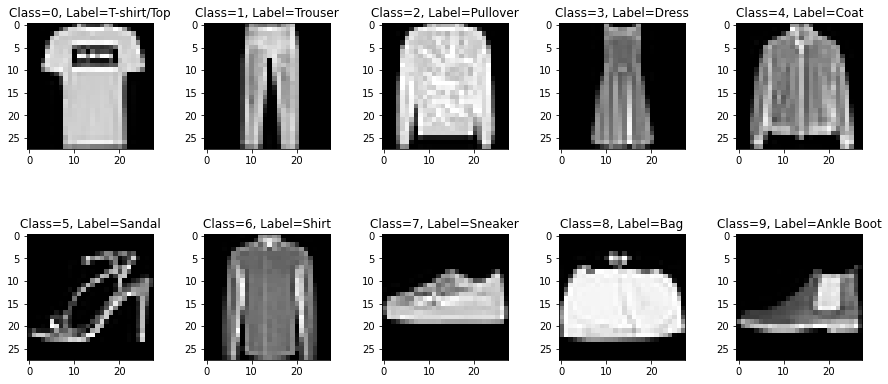

Epoch,▁▃▅▆█
Train Acc,▁▄▆▇█
Train Acc (squared_error),▁▅▆██
Train Loss,█▅▃▂▁
Train Loss (squared_error),█▄▃▁▁
Valid Acc,▁▅▇▇█
Valid Acc (squared_error),▁▅▅█▇
Valid Loss,█▄▂▁▁
Valid Loss (squared_error),█▄▄▁▃
test_acc,▁
test_acc (squared error),▁


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [94]:
wandb.agent(sweep_id, train)

#BEST_MODEL_2_ADAM

wandb: Agent Starting Run: f0zebrsc with config:
wandb: 	act_fun: relu
wandb: 	alpha: 0
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	eta: 0.001
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 2
wandb: 	optimizer: adam
wandb: 	strat: xavier


epoch: 1  cross_entropy  train_acc : 0.8614444444444445 valid_acc : 0.8713333333333333 test_acc : 0.8459
epoch: 2  cross_entropy  train_acc : 0.8754259259259259 valid_acc : 0.88 test_acc : 0.8568
epoch: 3  cross_entropy  train_acc : 0.8875925925925926 valid_acc : 0.8895 test_acc : 0.866
epoch: 4  cross_entropy  train_acc : 0.8962222222222223 valid_acc : 0.8896666666666667 test_acc : 0.8698
epoch: 5  cross_entropy  train_acc : 0.9022592592592592 valid_acc : 0.8921666666666667 test_acc : 0.8722


epoch: 1  squared_error  train_acc : 0.8611666666666666 valid_acc : 0.863 test_acc : 0.8465
epoch: 2  squared_error  train_acc : 0.8753333333333333 valid_acc : 0.8728333333333333 test_acc : 0.8572
epoch: 3  squared_error  train_acc : 0.8838703703703704 valid_acc : 0.876 test_acc : 0.8642
epoch: 4  squared_error  train_acc : 0.8917592592592593 valid_acc : 0.8781666666666667 test_acc : 0.8675
epoch: 5  squared_error  train_acc : 0.8925740740740741 valid_acc : 0.8783333333333333 test_acc : 0.862


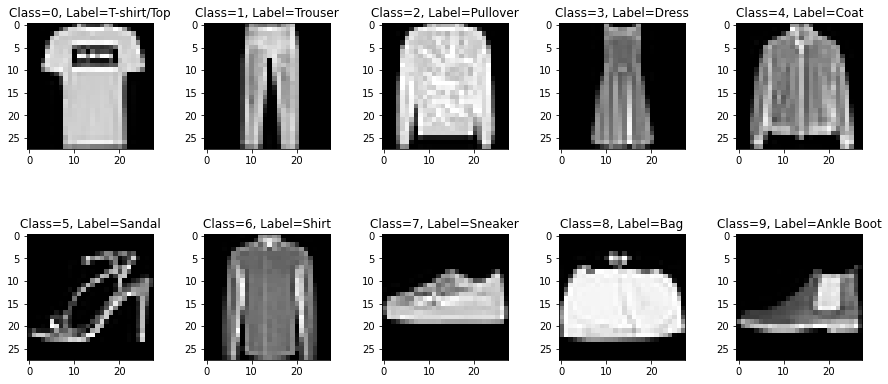

Epoch,▁▃▅▆█
Train Acc,▁▃▅▇█
Train Acc (squared_error),▁▄▆██
Train Loss,█▅▃▂▁
Train Loss (squared_error),█▅▃▁▁
Valid Acc,▁▄▇▇█
Valid Acc (squared_error),▁▅▇██
Valid Loss,█▅▃▁▁
Valid Loss (squared_error),█▄▂▁▁
test_acc,▁
test_acc (squared error),▁


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [107]:
#wandb.agent(sweep_id, train)

#NAG BEST MODEL With cross_entropy and sq_error loss functions

wandb: Agent Starting Run: ctcp55kj with config:
wandb: 	act_fun: relu
wandb: 	alpha: 0
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.001
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	optimizer: nag
wandb: 	strat: xavier


epoch: 1  cross_entropy  train_acc : 0.8492962962962963 valid_acc : 0.8493333333333334 test_acc : 0.8339
epoch: 2  cross_entropy  train_acc : 0.866462962962963 valid_acc : 0.8666666666666667 test_acc : 0.8479
epoch: 3  cross_entropy  train_acc : 0.8736481481481482 valid_acc : 0.865 test_acc : 0.8514
epoch: 4  cross_entropy  train_acc : 0.8805185185185185 valid_acc : 0.8678333333333333 test_acc : 0.8557
epoch: 5  cross_entropy  train_acc : 0.8838518518518519 valid_acc : 0.8725 test_acc : 0.8588


epoch: 1  squared_error  train_acc : 0.8386296296296296 valid_acc : 0.8415 test_acc : 0.825
epoch: 2  squared_error  train_acc : 0.8628703703703704 valid_acc : 0.8608333333333333 test_acc : 0.8463
epoch: 3  squared_error  train_acc : 0.8714259259259259 valid_acc : 0.8693333333333333 test_acc : 0.85
epoch: 4  squared_error  train_acc : 0.8758148148148148 valid_acc : 0.8716666666666667 test_acc : 0.8542
epoch: 5  squared_error  train_acc : 0.8883333333333333 valid_acc : 0.8771666666666667 test_acc : 0.8616


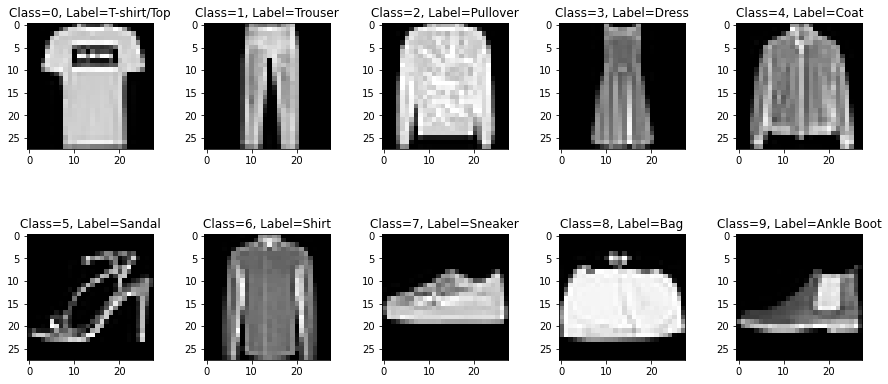

Epoch,▁▃▅▆█
Train Acc,▁▄▆▇█
Train Acc (squared_error),▁▄▆▆█
Train Loss,█▅▄▂▁
Train Loss (squared_error),█▅▃▃▁
Valid Acc,▁▆▆▇█
Valid Acc (squared_error),▁▅▆▇█
Valid Loss,█▅▃▂▁
Valid Loss (squared_error),█▄▃▃▁
test_acc,▁
test_acc (squared error),▁


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [58]:
#wandb.agent(sweep_id, train)

#MGD BEST MODEL with cross_entropy and sq_error loss functions

wandb: Agent Starting Run: 98wk3ymp with config:
wandb: 	act_fun: sigmoid
wandb: 	alpha: 0
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.01
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	optimizer: mgd
wandb: 	strat: xavier


epoch: 1  cross_entropy  train_acc : 0.7309629629629629 valid_acc : 0.7313333333333333 test_acc : 0.7251
epoch: 2  cross_entropy  train_acc : 0.8398703703703704 valid_acc : 0.8401666666666666 test_acc : 0.8224
epoch: 3  cross_entropy  train_acc : 0.8663148148148148 valid_acc : 0.8615 test_acc : 0.8439
epoch: 4  cross_entropy  train_acc : 0.8633148148148149 valid_acc : 0.8573333333333333 test_acc : 0.8421
epoch: 5  cross_entropy  train_acc : 0.8845740740740741 valid_acc : 0.8773333333333333 test_acc : 0.8592


epoch: 1  squared_error  train_acc : 0.6946666666666667 valid_acc : 0.6963333333333334 test_acc : 0.6894
epoch: 2  squared_error  train_acc : 0.8061296296296296 valid_acc : 0.804 test_acc : 0.7921
epoch: 3  squared_error  train_acc : 0.844037037037037 valid_acc : 0.8453333333333334 test_acc : 0.8295
epoch: 4  squared_error  train_acc : 0.8605 valid_acc : 0.859 test_acc : 0.8426
epoch: 5  squared_error  train_acc : 0.8699814814814815 valid_acc : 0.8671666666666666 test_acc : 0.8502


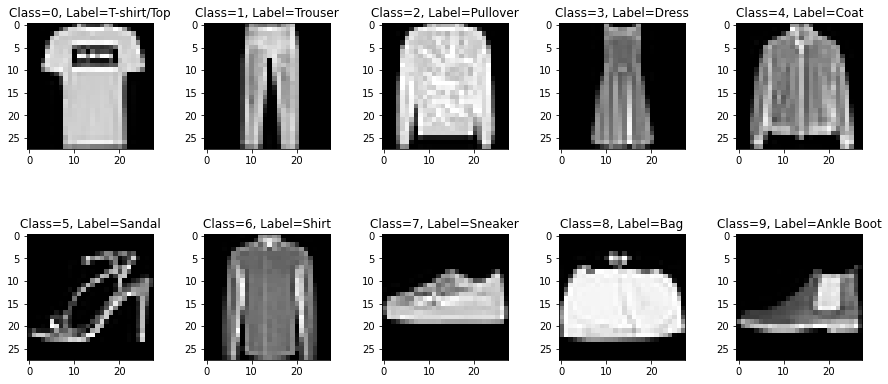

Epoch,▁▃▅▆█
Train Acc,▁▆▇▇█
Train Acc (squared_error),▁▅▇██
Train Loss,█▄▃▃▁
Train Loss (squared_error),█▄▂▁▁
Valid Acc,▁▆▇▇█
Valid Acc (squared_error),▁▅▇██
Valid Loss,█▄▂▃▁
Valid Loss (squared_error),█▄▂▁▁
test_acc,▁
test_acc (squared error),▁


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [55]:
#wandb.agent(sweep_id, train)

#SGD BEST MODEL with cross_entropy and sq_error loss functions

wandb: Agent Starting Run: ndtxzvxm with config:
wandb: 	act_fun: tanh
wandb: 	alpha: 0
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	eta: 0.01
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	optimizer: sgd
wandb: 	strat: xavier


epoch: 1  cross_entropy  train_acc : 0.8512222222222222 valid_acc : 0.8501666666666666 test_acc : 0.834
epoch: 2  cross_entropy  train_acc : 0.8691666666666666 valid_acc : 0.8648333333333333 test_acc : 0.8505
epoch: 3  cross_entropy  train_acc : 0.8785185185185185 valid_acc : 0.8706666666666667 test_acc : 0.855
epoch: 4  cross_entropy  train_acc : 0.8823518518518518 valid_acc : 0.8723333333333333 test_acc : 0.8613
epoch: 5  cross_entropy  train_acc : 0.8909259259259259 valid_acc : 0.88 test_acc : 0.8624


epoch: 1  squared_error  train_acc : 0.8389629629629629 valid_acc : 0.8443333333333334 test_acc : 0.8224
epoch: 2  squared_error  train_acc : 0.8663703703703703 valid_acc : 0.8691666666666666 test_acc : 0.8493
epoch: 3  squared_error  train_acc : 0.8729259259259259 valid_acc : 0.8703333333333333 test_acc : 0.8514
epoch: 4  squared_error  train_acc : 0.8792777777777778 valid_acc : 0.8775 test_acc : 0.8597
epoch: 5  squared_error  train_acc : 0.8909444444444444 valid_acc : 0.8826666666666667 test_acc : 0.8631


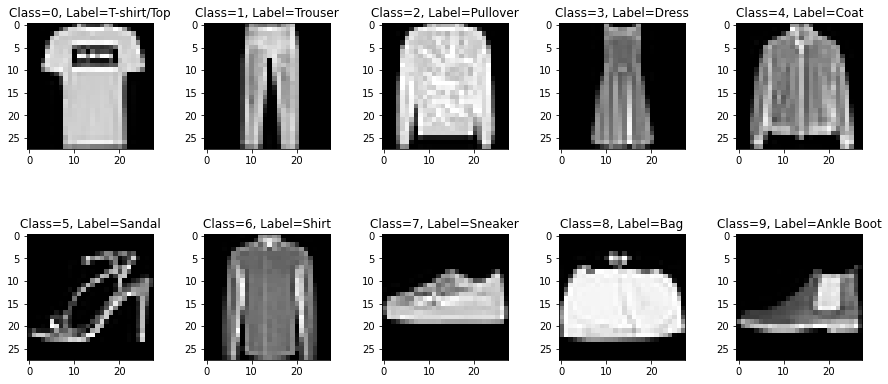

Epoch,▁▃▅▆█
Train Acc,▁▄▆▆█
Train Acc (squared_error),▁▅▆▆█
Train Loss,█▅▃▂▁
Train Loss (squared_error),█▄▃▂▁
Valid Acc,▁▄▆▆█
Valid Acc (squared_error),▁▆▆▇█
Valid Loss,█▄▂▂▁
Valid Loss (squared_error),█▄▃▂▁
test_acc,▁
test_acc (squared error),▁


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [52]:
#wandb.agent(sweep_id, train)